In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=[0.5], std=[0.5])
])

cuda_num = 0
batch_size = 32


In [3]:
mnist_dataset = MNIST('./MNIST', train=True, transform=image_transforms, download=True)


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw




Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw




Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw




Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



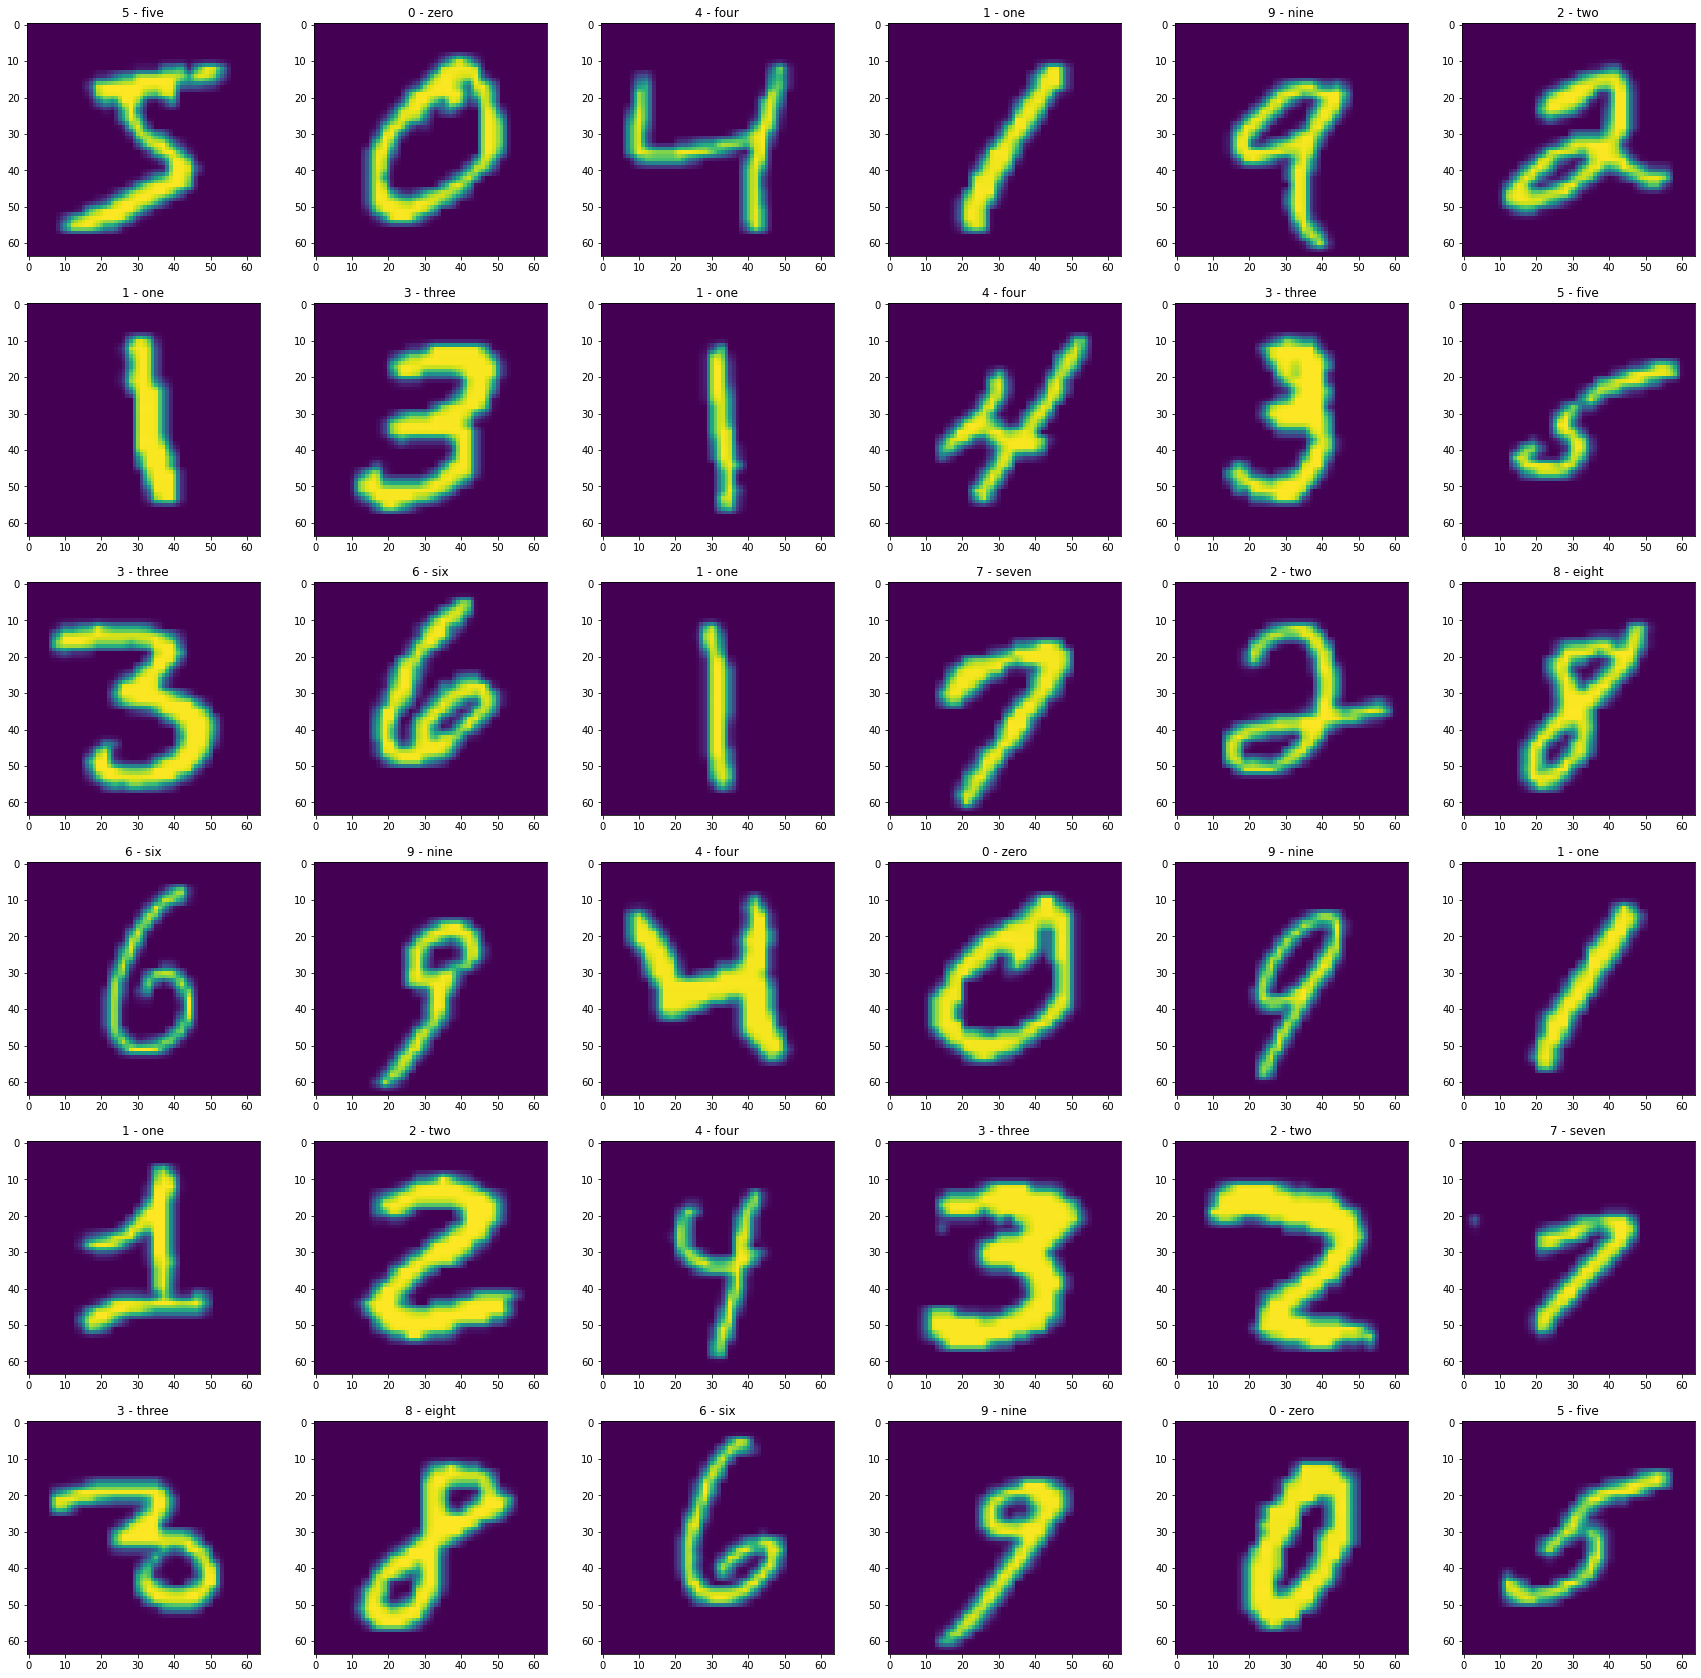

In [4]:
def process_image(image):
    # dim order is different between pytorch and numpy/plt
    # squeeze
    image = image.squeeze()
    # don't forget to detach your tensors
    image = image.detach()
    # here we do not need to use cuda
    image = image.to('cpu')
    # don't forget to unnomalize image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    return image

labels2name = {i: j for j, i in mnist_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(mnist_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()
    
    

In [5]:
class OnlyZerosDataset(torch.utils.data.Dataset):
    def __init__(self, mnist):
        self.images = []
        for image, label in tqdm(mnist):
            if label == 0:
                self.images.append(image)
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]

zeros_dataset = OnlyZerosDataset(mnist_dataset)
zeros_loader = DataLoader(zeros_dataset, batch_size=batch_size, drop_last=True)

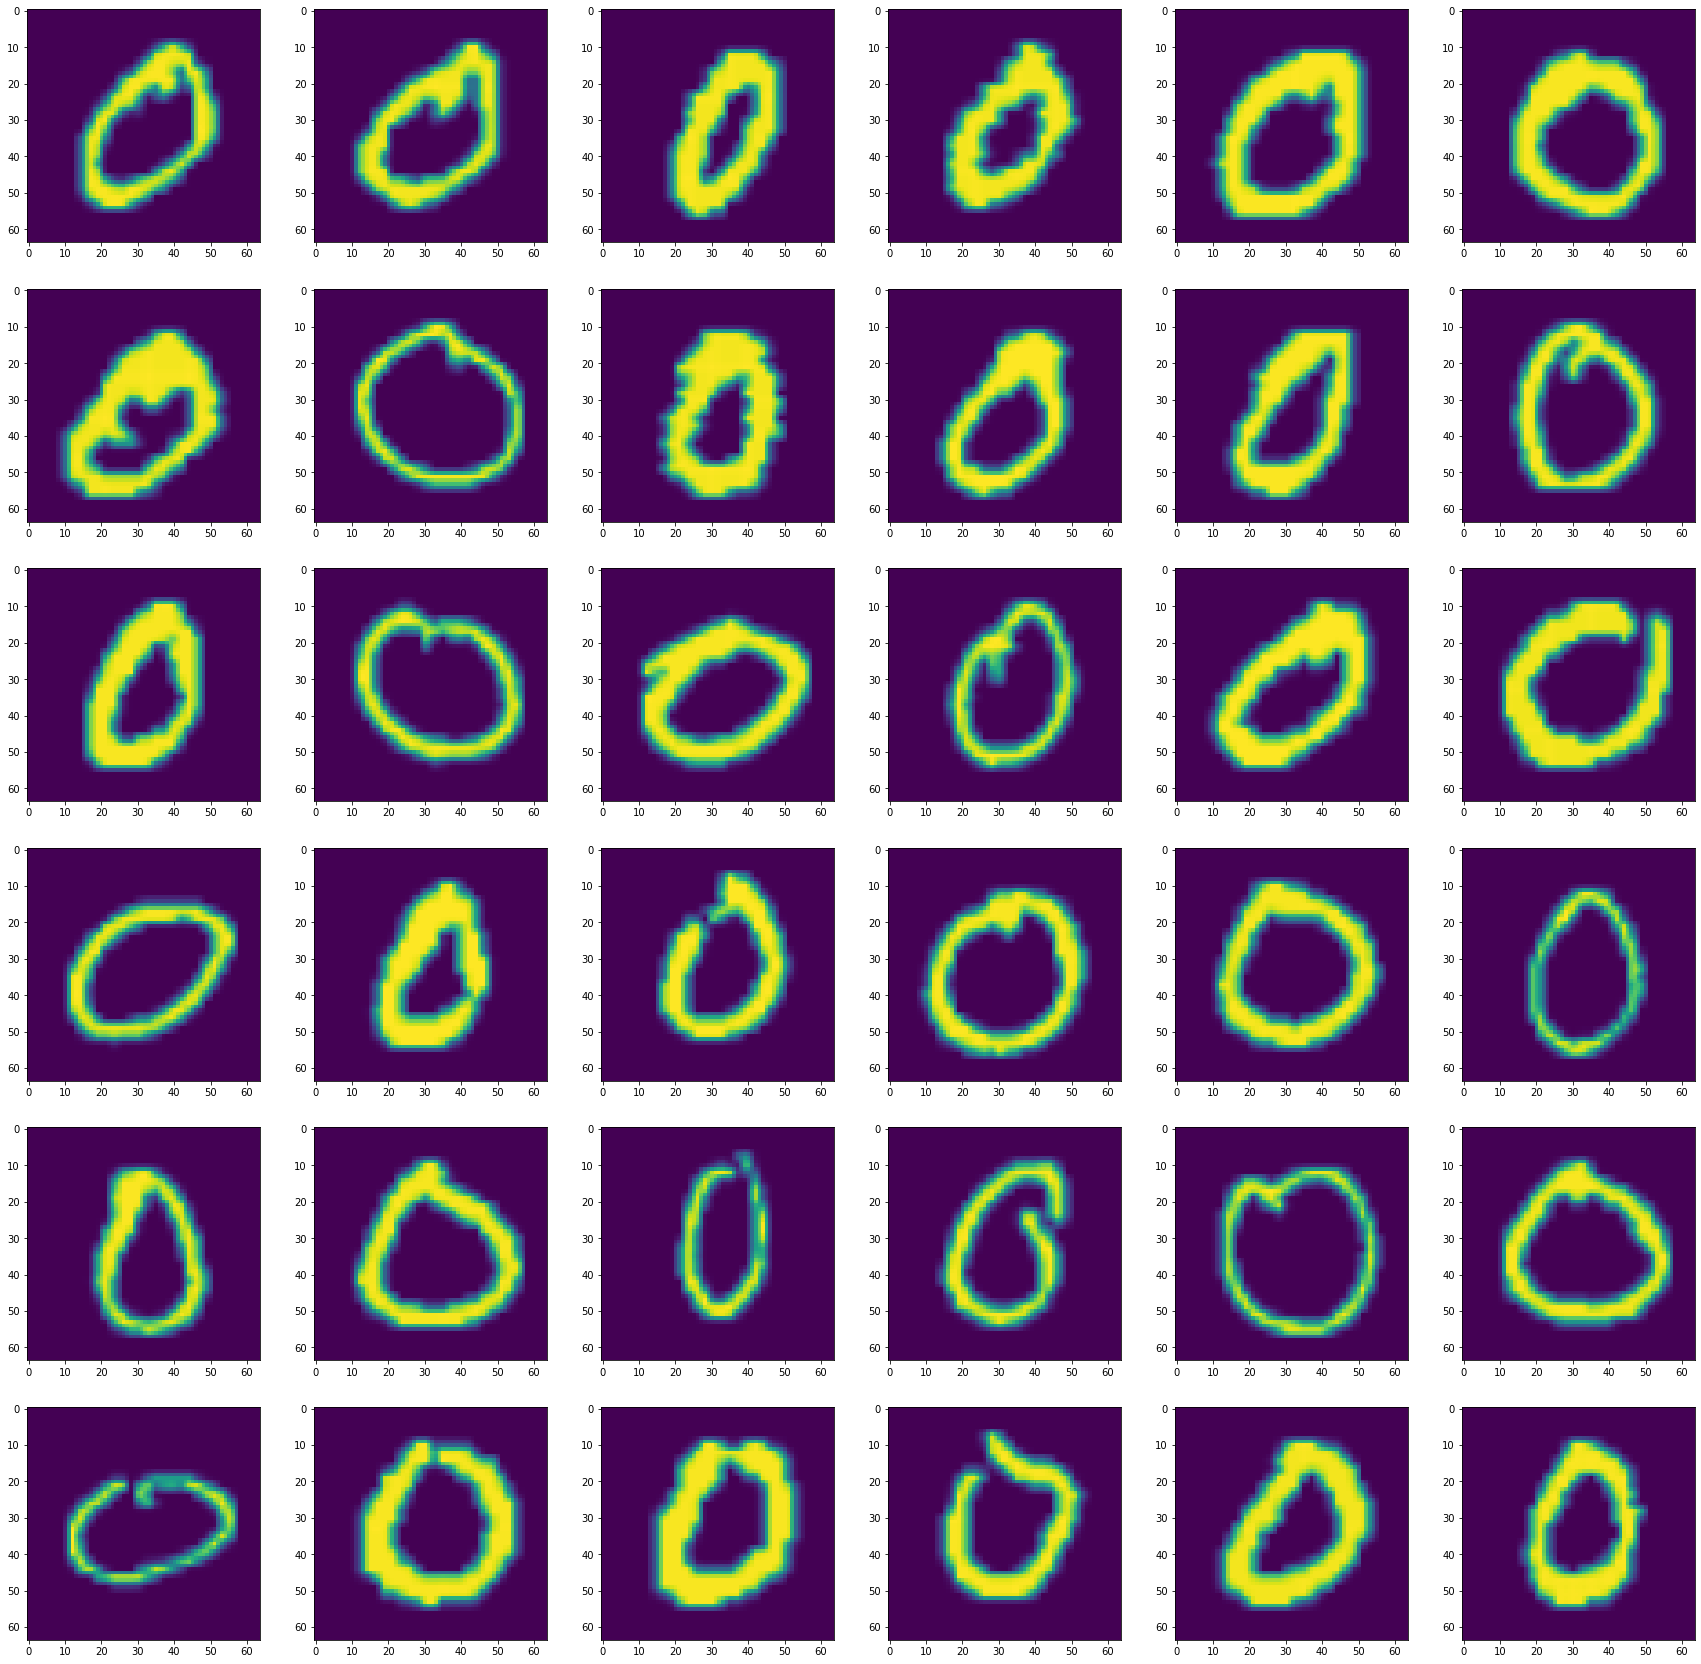

In [6]:
plt.figure(figsize=(30, 30))
for ind, image in enumerate(zeros_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()
    
    

![image](https://camo.githubusercontent.com/e43f336d6b83baf979de8ea558f34ccbe6713e1d/68747470733a2f2f6c696c69616e77656e672e6769746875622e696f2f6c696c2d6c6f672f6173736574732f696d616765732f47414e2e706e67)

In [7]:
class UpsampleBlock(nn.Module):
    def __init__(self, channels_from, channels_to):
        # https://discuss.pytorch.org/t/super-model-in-init/97426
        super().__init__()        
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(channels_from, channels_to, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_to),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channels_to, channels_to, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_to),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.layers(x)

In [8]:
class DownsampleBlock(nn.Module):
    def __init__(self, channels_from, channels_to):
        super().__init__()        
        self.layers = nn.Sequential(
            nn.Conv2d(channels_from, channels_to, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(channels_to),
            nn.LeakyReLU(0.2),
            nn.Conv2d(channels_to, channels_to, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels_to),
            nn.LeakyReLU(0.2)
        )
        
    def forward(self, x):
        return self.layers(x)

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            UpsampleBlock(4, 32), # 4x4 -> 8x8 
            UpsampleBlock(32, 64), # 8x8 -> 16x16
            UpsampleBlock(64, 128), # 16x16 -> 32x32
            UpsampleBlock(128, 256), # 32x32 -> 64x64
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Tanh()            
        )
            
    def forward(self, x):
        noise = torch.randn(x.shape[0], 4, 4, 4, device=x.device)
        return self.layers(noise)


In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            DownsampleBlock(1, 32), # 64x64 -> 32x32
            DownsampleBlock(32, 64), # 32x32 -> 16x16
            DownsampleBlock(64, 128), # 16x16 -> 8x8
            DownsampleBlock(128, 256), # 8x8 -> 4x4
            nn.Conv2d(256, 32, kernel_size=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 4 * 4, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
        )
            
    def forward(self, x):
        x = self.layers(x).view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [88]:
# device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
device = torch.device('cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizators = {
    'G': torch.optim.Adam(generator.parameters(), lr=0.0005),
    'D': torch.optim.Adam(discriminator.parameters(), lr=0.0001),   
}

losses = {
    'D': [],
    'G': []
}


In [92]:
for epoch in range(50):
    for images in tqdm(zeros_loader, position=0, leave=False):
        images = images.to(device)
        
        # train D
        optimizators['D'].zero_grad()

        fake_images = generator(images).detach()
        # todo add why detach
        out_real = discriminator(images)
        out_fake = discriminator(fake_images)
        
        real_loss = F.binary_cross_entropy_with_logits(out_real, torch.ones_like(out_real) * 0.9)
        fake_loss = F.binary_cross_entropy_with_logits(out_fake, torch.zeros_like(out_fake))
        
        loss = (real_loss + fake_loss) / 2
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        optimizators['D'].step()

        losses['D'].append(loss.item())
        # don't forget to use item
        
        # train G
        optimizators['G'].zero_grad()

        fake_images = generator(images)
        out_fake = discriminator(fake_images)
        
        loss = F.binary_cross_entropy_with_logits(out_fake, torch.ones_like(out_fake) * 0.9)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)

        optimizators['G'].step()
        
        losses['G'].append(loss.item())


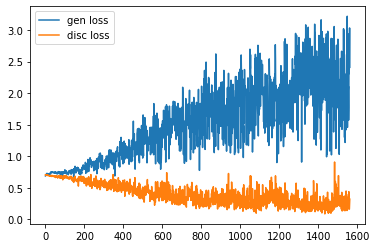

In [93]:
plt.plot(losses['G'], label='generator loss')
plt.plot(losses['D'], label='discriminator loss')
plt.legend()
plt.show()

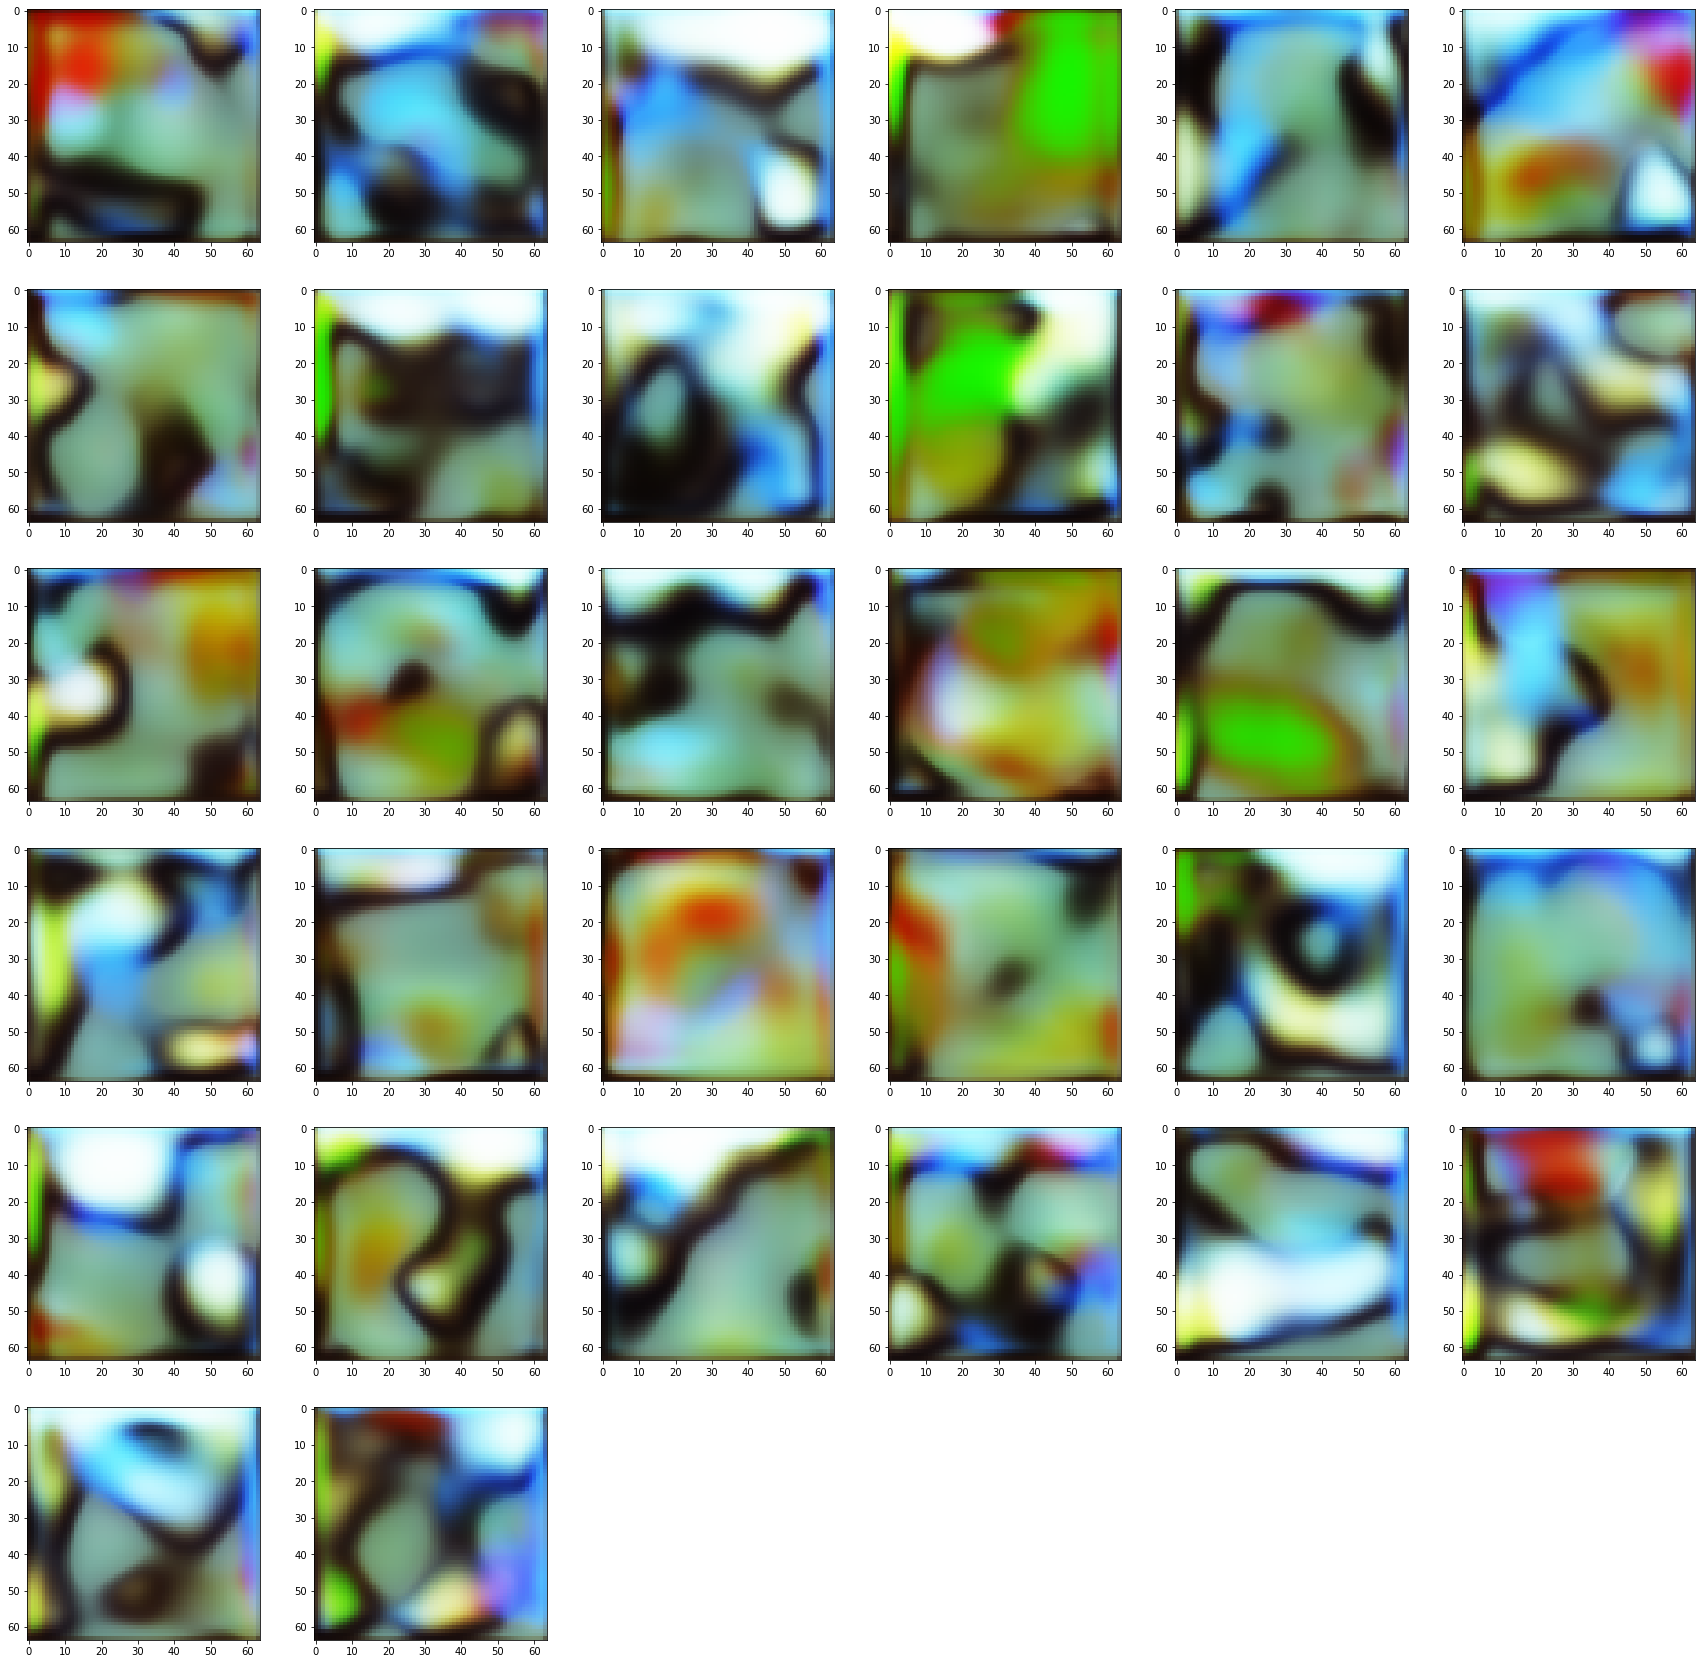

In [94]:
generated = generator(images).detach().to('cpu')

plt.figure(figsize=(30, 30))
for ind, image in enumerate(generated):
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
plt.show()


Как видите, все пришло не совсем туда куда мы хотели

Какие инженерные штуки можно попробовать:

1. One-sided label smoothing: (https://arxiv.org/pdf/1606.03498.pdf): Заменить label_true с 1 на 0.9
2. Gradient clipping (torch.nn.utils.clip_grad_norm_)
3. Decay latent variance on inference
4. Dropout in D.fc
5. Make D.fc fully convolutional
6. Balance G/D update rate

### Conditional GAN


In [116]:
class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

config = {
    'noise_channels': 4,
    'noise_shape': 4,
    'image_size': 64, 
    'image_channels': 3,
    'batch_size': 32,
    'num_attrs': 100,
    'device': f'cuda:{0}' if torch.cuda.is_available() else 'cpu',
    'max_epochs': 100,
    'grad_clip_value': 10
}

config = DotDict(config)

In [117]:
from torchvision.datasets import CIFAR100
from torchvision import transforms

from torch.utils.data import DataLoader

image_transforms = transforms.Compose([
    transforms.Resize((config.image_size, config.image_size)),
    transforms.ToTensor(),
    # https://discuss.pytorch.org/t/understanding-transform-normalize/21730
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [118]:
cifar_dataset = CIFAR100('./CIFAR100', train=True, transform=image_transforms, download=True)
cifar_loader = DataLoader(cifar_dataset, batch_size=config.batch_size, drop_last=True)

Files already downloaded and verified


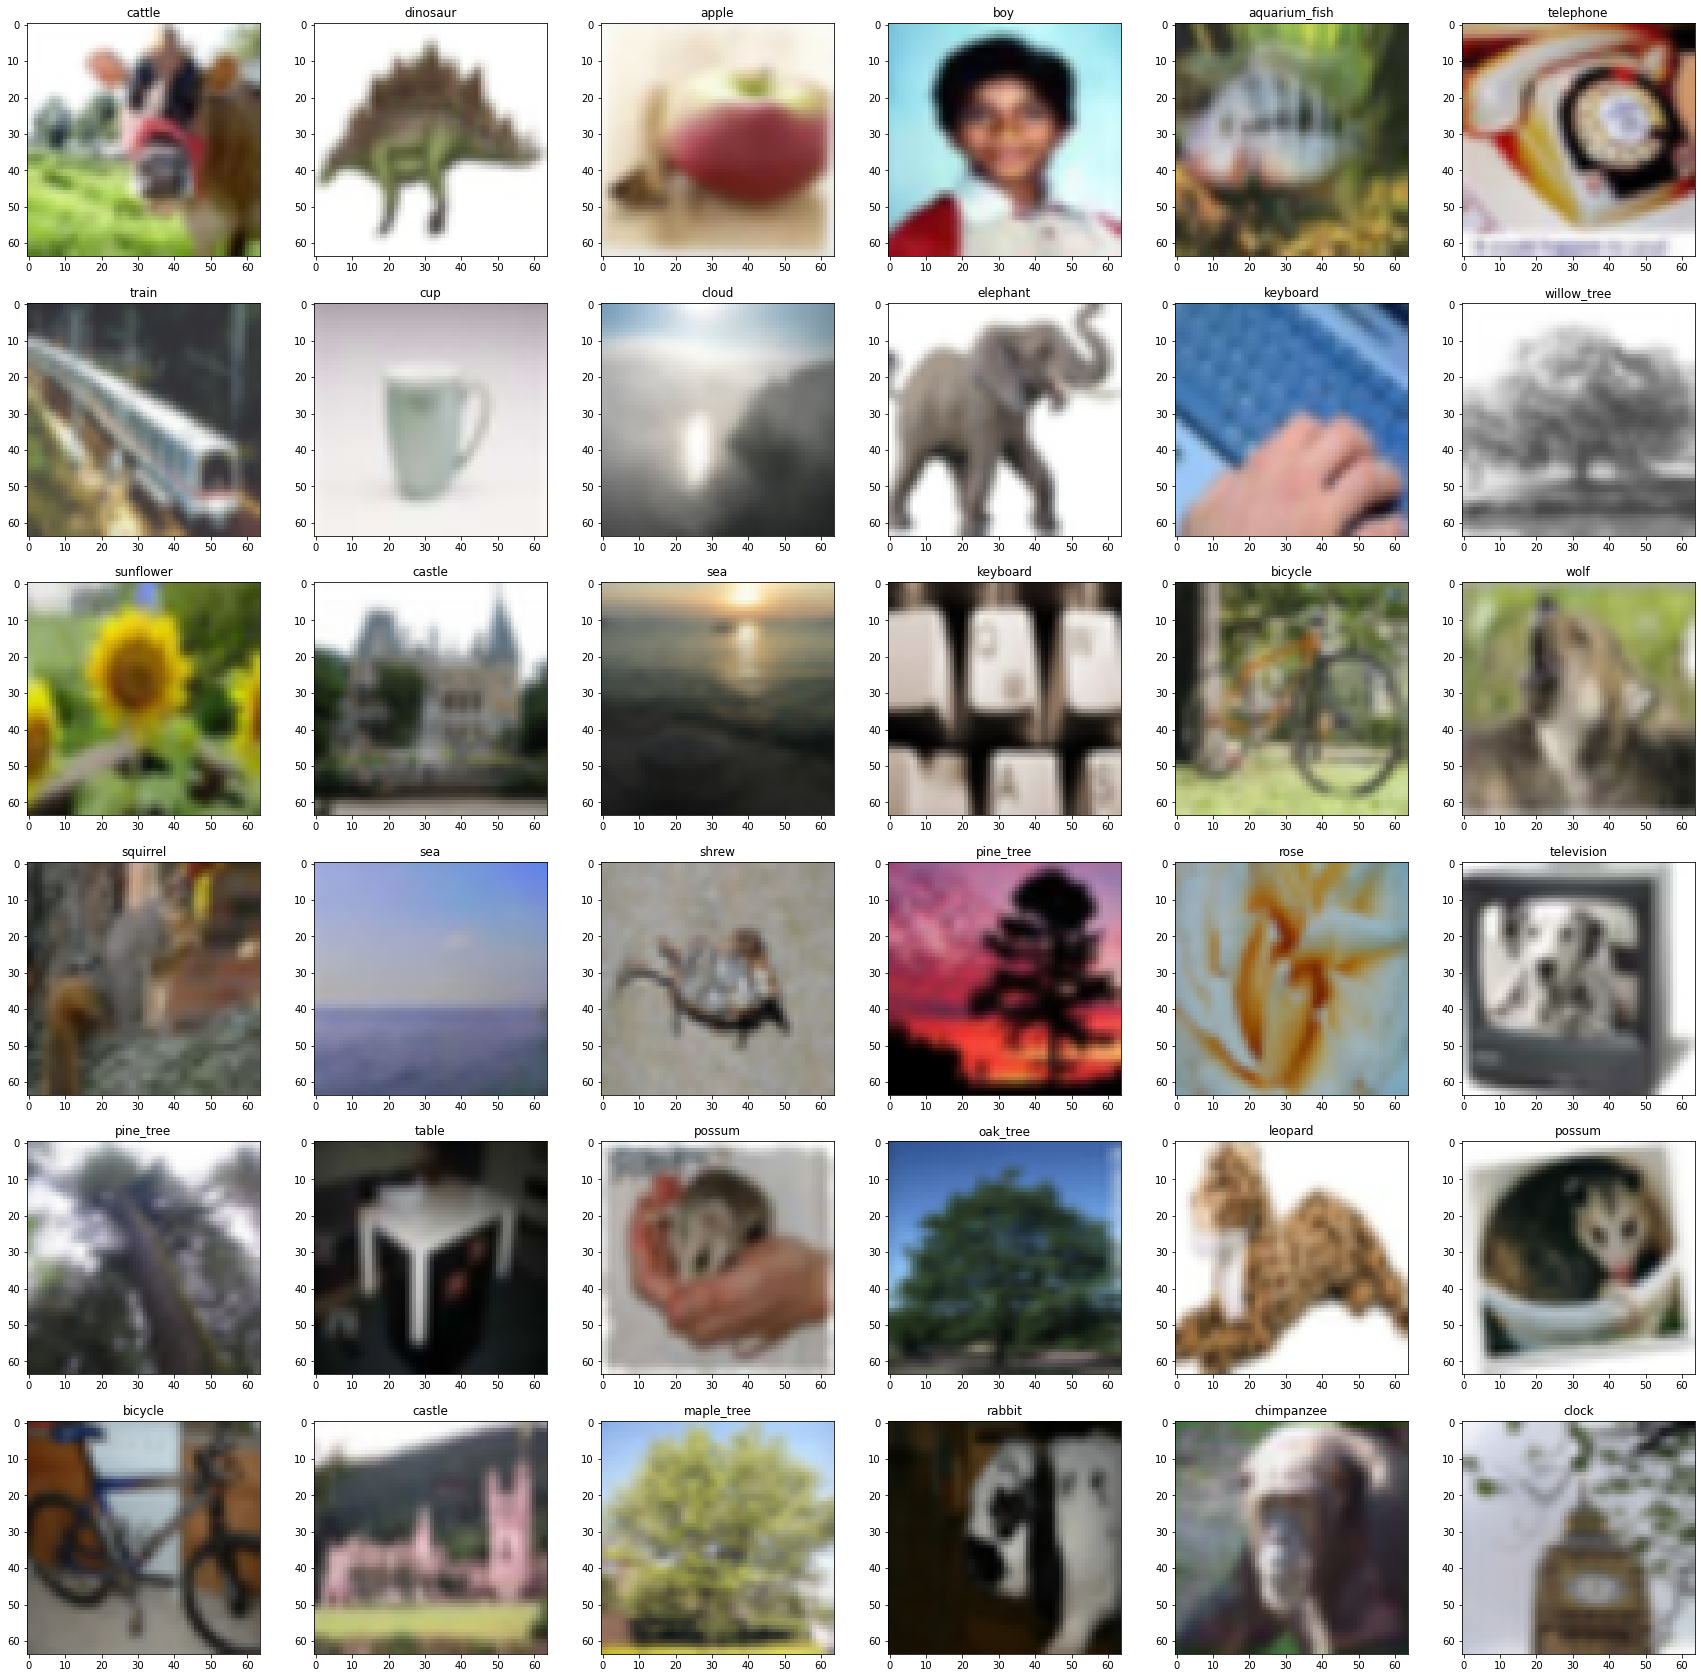

In [119]:
def process_image(image):
    # dim order is different between pytorch and numpy/plt
    image = image.permute(1, 2, 0)
    # don't forget to detach your tensors
    image = image.detach()
    # here we do not need to use cuda
    image = image.to('cpu')
    # don't forget to unnomalize image from [-1, 1] to [0, 1]
    image = (image + 1) / 2
    return image

labels2name = {i: j for j, i in cifar_dataset.class_to_idx.items()}


plt.figure(figsize=(30, 30))
for ind, (image, label) in enumerate(cifar_dataset):
    if ind >= 6*6: break
    plt.subplot(6, 6, ind+1)
    plt.imshow(process_image(image))
    plt.title(labels2name[label])
plt.show()
    
    

In [133]:
class Generator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.label_embedding = nn.Embedding(config.num_attrs,
                                            embedding_dim=self.config.noise_shape * self.config.noise_shape)
        self.layers = self._build_layers()
        
    def _build_layers(self):
        layers = []
        image_size = self.config.noise_shape
        channels_from = self.config.noise_channels
        channels_to = self.config.noise_channels * 2
        while image_size != self.config.image_size:
            if image_size == self.config.noise_shape:
                layers.append(UpsampleBlock(channels_from + 1, channels_to))
            else:
                layers.append(UpsampleBlock(channels_from, channels_to))
            channels_from, channels_to = channels_to, channels_to * 2 
            image_size *= 2
        layers.append(
            nn.Sequential(
                nn.Conv2d(channels_from, self.config.image_channels, kernel_size=1),
                nn.Tanh()
            )
        )
        return nn.Sequential(*layers)
        
    
    def _sample_latent(self, x, reduce_noise):
        noise = torch.randn(x.shape[0], self.config.noise_channels,
                            self.config.noise_shape, self.config.noise_shape,
                            device=x.device)
        if reduce_noise:
            noise *= 0.7
        return noise
    
    def forward(self, x, labels, reduce_noise=False):
        labels = self.label_embedding(labels).view(-1, 1, self.config.noise_shape, self.config.noise_shape)
        noise = self._sample_latent(x, reduce_noise)
        noise = torch.cat([noise, labels], dim=1)
        return self.layers(noise)


In [138]:
class Discriminator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.label_embedding = nn.Embedding(config.num_attrs,
                                            embedding_dim=self.config.image_size * self.config.image_size)
        self.layers = self._build_layers()
        self.fc = self._build_fc()
        
    def _build_layers(self):
        layers = []
        image_size = self.config.image_size
        channels_from = 32
        channels_to = 32
        while image_size != self.config.noise_shape:
            if image_size == self.config.image_size:
                layers.append(DownsampleBlock(self.config.image_channels+1, channels_to))
            else:
                layers.append(DownsampleBlock(channels_from, channels_to))
                
            channels_from, channels_to = channels_to, channels_to // 2
            image_size //= 2
        return nn.Sequential(*layers)
    
    def _build_fc(self):
        layers = nn.Sequential(
            nn.Linear(self.config.noise_channels * self.config.noise_shape * self.config.noise_shape, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            # note that we don't use sigmoid
        )
        return nn.Sequential(*layers)
            
    def forward(self, x, labels):
        labels = self.label_embedding(labels).view(-1, 1, self.config.image_size, self.config.image_size)
        x = torch.cat([x, labels], dim=1)
        x = self.layers(x).view(x.shape[0], -1)
        x = self.fc(x)
        return x


In [139]:
class GAN:
    def __init__(self, config):
        self.config = config
        self.models = {
            'G': Generator(config),
            'D': Discriminator(config)
        }
        self.optims = {
            'G': torch.optim.Adam(self.models['G'].parameters(), lr=0.001),
            'D': torch.optim.Adam(self.models['D'].parameters(), lr=0.0005)
        }
        
    def trainD(self, x, label):
        self.optims['D'].zero_grad()
        fake_images = self.models['G'](x, label).detach()
        out_real = self.models['D'](images, label)
        out_fake = self.models['D'](fake_images, label)
        
        real_loss = F.binary_cross_entropy_with_logits(out_real, torch.ones_like(out_real) * 0.9)
        fake_loss = F.binary_cross_entropy_with_logits(out_fake, torch.zeros_like(out_fake))
        
        loss = (real_loss + fake_loss) / 2
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.models['D'].parameters(), config.grad_clip_value)
        self.optims['D'].step()
        return loss.item()

    def trainG(self, x, label):
        self.optims['G'].zero_grad()

        fake_images = self.models['G'](x, label)
        out_fake = self.models['D'](fake_images, label)
        
        loss = F.binary_cross_entropy_with_logits(out_fake, torch.ones_like(out_fake) * 0.9)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.models['G'].parameters(), config.grad_clip_value)
        self.optims['G'].step()
        return loss.item()

    @torch.no_grad()
    def generate(self, x, label):
        return self.models['G'](x, label, reduce_noise=True)

In [140]:
gan = GAN(config)

In [ ]:
from IPython.display import clear_output

losses = {
    'D': [],
    'G': []
}

for epoch in range(config.max_epochs):
    for images, labels in tqdm(cifar_loader, position=0, leave=False):
        images = images.to(device)
        
        losses['D'].append(gan.trainD(images, labels))
        losses['G'].append(gan.trainG(images, labels))
    
    clear_output()
    plt.plot(losses['G'], label='generator loss')
    plt.plot(losses['D'], label='discriminator loss')
    plt.legend()
    plt.show()
    
    generated = gan.generate(images, labels).to('cpu')
    plt.figure(figsize=(30, 30))
    for ind, image in enumerate(generated):
        if ind >= 36: break
        plt.subplot(6, 6, ind+1)
        plt.imshow(process_image(image))
    plt.show()


# f-Gan

In [11]:
class Activation_g(nn.Module):
    def __init__(self,divergence="GAN"):
        super(Activation_g,self).__init__()
        self.divergence =divergence
    def forward(self,v):
        divergence = self.divergence
        if divergence == "KLD":
            return v
        elif divergence == "RKL":
            return -torch.exp(-v)
        elif divergence == "CHI":
            return v
        elif divergence == "SQH":
            return 1-torch.exp(-v)
        elif divergence == "JSD":
            return torch.log(torch.tensor(2.))-torch.log(1.0+torch.exp(-v))
        elif divergence == "GAN":
            return -torch.log(1.0+torch.exp(-v)) # log sigmoid

In [12]:
class Conjugate_f(nn.Module):
    def __init__(self,divergence="GAN"):
        super(Conjugate_f,self).__init__()
        self.divergence = divergence
    def forward(self,t):
        divergence= self.divergence
        if divergence == "KLD":
            return torch.exp(t-1)
        elif divergence == "RKL":
            return -1 -torch.log(-t)
        elif divergence == "CHI":
            return 0.25*t**2+t
        elif divergence == "SQH":
            return t/(torch.tensor(1.)-t)
        elif divergence == "JSD":
            return -torch.log(2.0-torch.exp(t))
        elif divergence == "GAN":
            return  -torch.log(1.0-torch.exp(t))

In [13]:
class VLOSS(nn.Module):
    def __init__(self,divergence="GAN"):
        super(VLOSS,self).__init__()
        self.activation = Activation_g(divergence)
    def forward(self,v):
        return torch.mean(self.activation(v))

In [14]:
class QLOSS(nn.Module):
    def __init__(self,divergence="GAN"):
        super(QLOSS,self).__init__()
        self.conjugate = Conjugate_f(divergence)
        self.activation = Activation_g(divergence)
    def forward(self,v):
        return torch.mean(-self.conjugate(self.activation(v)))


In [16]:
import torch.optim as optim

device = torch.device('cpu')


Q_net = Generator().to(device)
V_net = Discriminator().to(device)

divergence = "SQH" # GAN, KLD, JSD, RKL,SQH, CHI 
Q_criterion =QLOSS(divergence)
V_criterion =VLOSS(divergence)


Q_optimizer = optim.Adam(Q_net.parameters(),lr=2e-4,betas=(0.5,0.9))
V_optimizer = optim.Adam(V_net.parameters(),lr=2e-4,betas=(0.5,0.9))
# fixed_noise = torch.randn(batch_size, 4, 4, 4, device=x.device)

epochs = 10

In [ ]:
for ep in range(epochs):
    for images in tqdm(zeros_loader, position=0, leave=False):
        b_size = images.shape[0]
        images = images.to(device)

        #Train V
        V_net.zero_grad()

        v = V_net(images)
        loss_real = -V_criterion(v)
        loss_real.backward(retain_graph=True)

        fake_data = Q_net(images)
        v_fake = V_net(fake_data.detach())
        loss_fake = -Q_criterion(v_fake)
        loss_fake.backward()#maximize F

        loss_V = -(loss_real + loss_fake)
        V_optimizer.step()

        #Train G 
        Q_net.zero_grad()
        v_fake = V_net(fake_data)

        #loss_Q = Q_criterion(v_fake)# minimize F
        loss_Q = -V_criterion(v_fake)# maximize F (trick way)
        loss_Q.backward()
        Q_optimizer.step()
